### Imports

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

import itertools
from environment.evaluation import *
from environment.data_loader import *
import random
from datetime import datetime
import numpy as np
from datetime import timedelta

### Config

In [2]:
colors = {
    "DQN": 'darkorange',
    "REINFORCE": 'forestgreen',
    "ODT": 'blueviolet',
}

season_colors = {
    "winter": 'blue',
    "spring": 'forestgreen',
    "summer": 'gold',
    "autumn": 'darkorange'
}

experiments = list(itertools.chain(
    range(4000, 4180),
    range(5000, 5180),
    range(6000, 6180),
))

## Figure 4

### Loading data

In [3]:
target_agg_count = 10

exp_power_data = []

for ind, exp_num in enumerate(experiments):
    config_fname = f'../experiments/Exp_{exp_num}/config.yaml'
    
    c = load_config_file(config_fname)
    nn_c = c['nn_hyperparameters']
    federated_c = c['federated_learning_settings']
    algo_c = c['algorithm_settings']

    if algo_c == 'ODT':
        target_agg_count = 4
    
    env_c = c['environment_settings']
    eval_c = c['eval_config']
    
    ev_info = []

    seed = env_c['seed']

    algorithm_dm = algo_c['algorithm']
    
    def load_from_json_with_error_handling(filepath, columns_specific):
        try:
            return read_csv_data(filepath, columns=columns_specific)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON from {filepath}: {e.msg} at line {e.lineno}, column {e.colno}")
            return None  # Handle the error and return None or an empty object
    
    
    d_base = f"../../../../storage_1/metrics/Exp_{exp_num}"
    
    if not os.path.exists(d_base):
        d_base = f"../metrics/Exp_{exp_num}"
            
    base_path = f"{d_base}/train/"

    print(f'Loading {base_path}power_and_co2_metrics.csv')
    power_data = load_from_json_with_error_handling(f'{base_path}power_and_co2_metrics.csv', ['time', 'power', 'co2'])

    power_data['seed'] = seed
    power_data['exp_num'] = exp_num
    
    power_data['algorithm'] = algorithm_dm
    power_data['season'] = env_c['season']
    power_data['num_aggs'] = federated_c['aggregation_count']
    power_data['eps_per_agg'] = nn_c['num_episodes']

    exp_power_data.append(power_data)

# Convert data to DataFrame for easier manipulation
df_power = pd.concat(exp_power_data, ignore_index=True)

# REMOVE CMA temp
df_power = df_power[df_power['algorithm'] != 'CMA']

df_power['cumulative_power'] = df_power.groupby('exp_num')['power'].cumsum()

df_power['time'] = pd.to_datetime(df_power['time'], errors='coerce')
df_power['time'] = df_power.groupby('exp_num')['time'].transform(lambda x: (x - x.min()).dt.total_seconds())

df_power['co2'] = df_power['co2'] * 1000 # Convert to grams

# Convert 3 aggs to 1 for CMA
df_power['num_aggs'] = np.where(
    (df_power['num_aggs'] == 3) & 
    (df_power['algorithm'] == 'CMA'), 
    1, 
    df_power['num_aggs']
)

final_times = df_power.groupby('exp_num')['time'].max().reset_index()
final_times.rename(columns={'time': 'final_time'}, inplace=True)

final_times = final_times.merge(df_power[['exp_num', 'num_aggs']].drop_duplicates(), on='exp_num')

average_final_time = final_times.groupby('num_aggs')['final_time'].mean().reset_index()

average_final_time['agg_label'] = average_final_time['num_aggs'].apply(lambda x: f"{x} Aggregations")

def seconds_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    secs = seconds % 60
    return f"{int(hours):02}:{int(minutes):02}:{int(secs):02}"

Loading ../../../../storage_1/metrics/Exp_4000/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4001/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4002/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4003/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4004/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4005/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4006/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4007/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4008/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4009/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4010/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4011/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4012/train

### Displaying figure

24.944537037037037
20.970856481481484


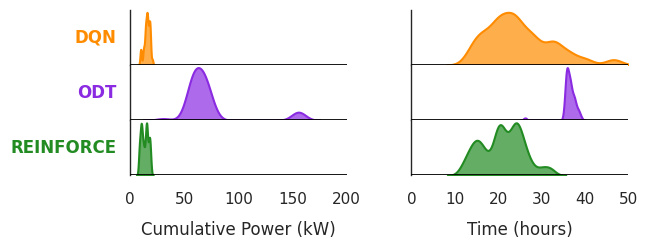

In [4]:
# Ensure output directory exists
os.makedirs("Figures", exist_ok=True)

# 1) Prepare finals DataFrame
df_10 = df_power[(df_power.num_aggs == 10) & (df_power.exp_num != 4129)].copy()
finals = (
    df_10
    .sort_values("time")
    .groupby(["algorithm", "exp_num"], as_index=False)
    .last()[["algorithm", "exp_num", "time", "cumulative_power"]]
)
finals["hours"] = finals["time"] / 3600.0
finals["cum_kW"] = finals["cumulative_power"] / 1000.0

# 2) Add DQN “pre-run” onto ODT runs
mean_dqn_time = finals.loc[finals['algorithm'] == 'DQN', 'hours'].mean()
mean_reinforce_time = finals.loc[finals['algorithm'] == 'REINFORCE', 'hours'].mean()

mean_dqn_kw = finals.loc[finals['algorithm'] == 'DQN', 'cum_kW'].mean()
mean_reinforce_kw = finals.loc[finals['algorithm'] == 'REINFORCE', 'cum_kW'].mean()

print(mean_dqn_time)
print(mean_reinforce_time)

def add_to_odt(row):
    if row.algorithm == "ODT":
        # get the trailing number (last 3 digits) of exp_num
        exp_str = str(row.exp_num)
        try:
            suffix = int(exp_str[-3:])
        except ValueError:
            # if it can’t be parsed, treat as “not in DQN range”
            suffix = None

        # if the suffix is between 108 and 144 inclusive, use DQN time
        if suffix is not None and 108 <= suffix <= 144:
            row.hours   += mean_dqn_time
            row.cum_kW  += mean_dqn_kw
        else:
            row.hours   += mean_reinforce_time
            row.cum_kW  += mean_reinforce_kw

    return row

    
finals = finals.apply(add_to_odt, axis=1)

# 3) Theme & palette
sns.set_theme(style="white")
palette = sns.cubehelix_palette(finals.algorithm.nunique(), rot=-.25, light=.7)

# 4) Plot ridgelines side-by-side
algos = finals.algorithm.unique()
n = len(algos)
fig, axes = plt.subplots(n, 2, figsize=(6, n * 0.65), sharex='col')

cum_min, cum_max = finals["cum_kW"].min(), finals["cum_kW"].max()
hr_min, hr_max   = finals["hours"].min(), finals["hours"].max()

for i, algo in enumerate(algos):
    data, color = finals[finals.algorithm == algo], palette[i]

    # ── LEFT column: cumulative power ────────────────────
    ax = axes[i, 0]
    sns.kdeplot(data.cum_kW, bw_adjust=0.5, fill=True, alpha=0.7,
                linewidth=1.5, common_norm=False, ax=ax, color=colors[algo])
    ax.set_xlim(cum_min, cum_max)
    ax.set_ylabel("")        # clear any old label
    ax.set_yticks([])
    ax.tick_params(left=False)

    # full-width thick baseline
    ax.axhline(0, color='black', linewidth=2, zorder=5)

    # x-ticks only on bottom row
    if i < n-1:
        ax.tick_params(axis='x', bottom=False, labelbottom=False)
    else:
        ax.set_xlabel("Cumulative Power (kW)", labelpad=10)
        xt = np.unique(np.concatenate(([0], ax.get_xticks())))
        ax.set_xticks(xt)
        ax.tick_params(axis='x', pad=6)

    # **new**: put algo name outside on the left
    ax.set_ylabel(algo,
                  rotation=0,
                  ha='right',
                  va='center',
                  labelpad=10,
                  color=colors[algo],
                  fontweight='bold')

    # hide unwanted spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_visible(False)


    # ── RIGHT column: run time ────────────────────
    ax = axes[i, 1]
    
    sns.kdeplot(data.hours, bw_adjust=0.5, fill=True, alpha=0.7,
                linewidth=1.5, common_norm=False, ax=ax, color=colors[algo])
    ax.set_xlim(hr_min, hr_max)
    ax.set_ylabel(""); ax.set_yticks([]); ax.tick_params(left=False)
    ax.axhline(0, color='black', linewidth=2, zorder=5)

    if i < n-1:
        ax.tick_params(axis='x', bottom=False, labelbottom=False)
    else:
        ax.set_xlabel("Time (hours)", labelpad=10)
        xt = np.unique(np.concatenate(([0], ax.get_xticks())))
        ax.set_xticks(xt)
        ax.tick_params(axis='x', pad=6)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_visible(False)

# overall layout
fig.subplots_adjust(
    top=0.90,
    bottom=0.05,
    left=0.15,   # ← more room for the outside labels
    right=0.98,
    hspace=0.0,
    wspace=0.3,
)

# save & show
out_path = os.path.join("figures", "ridgeline.png")
fig.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()

## Table 2

### Loading data

In [5]:
# Uses same data as previous figure

### Printing data for table

In [6]:
# Function to calculate energy in kWh for a single experiment
def calculate_energy_kWh(exp_data):
    # Sort the data by elapsed time
    exp_data_sorted = exp_data.sort_values('time')
    
    # Extract power (W) and time (s)
    power = exp_data_sorted['power'].values  # Power in W
    time_sec = exp_data_sorted['time'].values  # Time in seconds
    
    # Convert time to hours for integration
    time_hours = time_sec / 3600  # Convert seconds to hours
    
    # Handle cases where time_hours may not be strictly increasing
    # Ensure that time_hours is sorted and unique
    if not np.all(np.diff(time_hours) >= 0):
        raise ValueError("Time data must be sorted and non-decreasing for integration.")
    
    # Integrate power over time using the trapezoidal rule to get energy in Wh
    energy_Wh = np.trapz(power, time_hours)  # Integration: ∫ P(t) dt
    
    # Convert Wh to kWh
    energy_kWh = energy_Wh / 1000
    
    return energy_kWh

results = []

finals['adj_hours'] = finals['hours']

# group by algorithm and compute mean & standard deviation
stats = (
    finals
    .groupby('algorithm')['adj_hours']
    .agg(['mean','std', 'min', 'max'])
    .rename(columns={'mean':'avg_hours','std':'std_hours', 'min': 'min_hours', 'max': 'max_hours'})
)

duration_results = {"DQN": {}, "REINFORCE": {}, "ODT": {}}

print("Algorithm    Mean (h)    Std Dev (h)    Min (h)    Max (h)")

for algo, row in stats.iterrows():
    duration_results[algo] = {
        "Mean (h)": row.avg_hours,
        "Std Dev (h)": row.std_hours
    }

    print(f"{algo: <12}{row.avg_hours:>8.3f}{row.std_hours:>12.3f}{row.min_hours:>12.3f}{row.max_hours:>12.3f}")

# Iterate over each unique algorithm in the DataFrame
for algo in df_power['algorithm'].unique():
    # Filter data for the current algorithm
    algo_data = df_power[df_power['algorithm'] == algo]
    
    # Group by 'exp_num' to process each experiment separately
    grouped = algo_data.groupby('exp_num')
    
    # Initialize lists to store energy and CO2 for each experiment
    energy_kWh_list = []
    co2_list = []
    
    # Iterate over each experiment within the algorithm
    for exp_num, exp_data in grouped:
        try:
            # Calculate energy in kWh for the experiment
            energy_kWh = calculate_energy_kWh(exp_data)
            energy_kWh_list.append(energy_kWh)
            
            # Assume 'co2' is recorded at each time point; take the last entry as total CO2
            co2_total = exp_data['co2'].iloc[-1]
            co2_list.append(co2_total)
        except ValueError as e:
            print(f"Error processing Algorithm {algo}, Experiment {exp_num}: {e}")
    
    # Convert lists to NumPy arrays for statistical calculations
    energy_kWh_array = np.array(energy_kWh_list)
    co2_array = np.array(co2_list)
    
    # Calculate mean and standard deviation for energy
    avg_energy_kWh = energy_kWh_array.mean()
    std_energy_kWh = energy_kWh_array.std()
    
    # Calculate mean and standard deviation for CO2 emissions
    avg_co2 = co2_array.mean()
    std_co2 = co2_array.std()
    
    # Print the metrics with updated units
    print(f"Algorithm {algo} Power and CO2 Metrics")
    print(f"\tAverage energy used per experiment: {avg_energy_kWh:.4f} kWh")
    print(f"\tStandard deviation of energy used per experiment: {std_energy_kWh:.4f} kWh")
    print(f"\tAverage CO2 estimated emissions per experiment: {avg_co2:.4f} g")
    print(f"\tStandard deviation of CO2 estimated emissions per experiment: {std_co2:.4f} g\n")

    results.append([algo, duration_results[algo]["Mean (h)"], duration_results[algo]["Std Dev (h)"], avg_energy_kWh, std_energy_kWh, avg_co2, std_co2])

results_df = pd.DataFrame(results, columns=["Algorithm", "Mean (h)", "Std Dev (h)", "Avg Energy Used (kWh)", "Std Energy Used (kWh)", "Avg CO2 (g)", "Std CO2 (g)"])

results_df.to_csv('./table_data/table_2.csv', index=False)

Algorithm    Mean (h)    Std Dev (h)    Min (h)    Max (h)
DQN           24.945       7.629      13.700      46.667
ODT           36.465       1.689      26.221      39.071
REINFORCE     20.971       4.926      11.900      32.019
Algorithm DQN Power and CO2 Metrics
	Average energy used per experiment: 0.8796 kWh
	Standard deviation of energy used per experiment: 0.3771 kWh
	Average CO2 estimated emissions per experiment: 0.4410 g
	Standard deviation of CO2 estimated emissions per experiment: 0.1888 g

Algorithm REINFORCE Power and CO2 Metrics
	Average energy used per experiment: 0.6998 kWh
	Standard deviation of energy used per experiment: 0.3938 kWh
	Average CO2 estimated emissions per experiment: 0.3509 g
	Standard deviation of CO2 estimated emissions per experiment: 0.1972 g

Algorithm ODT Power and CO2 Metrics
	Average energy used per experiment: 3.2067 kWh
	Standard deviation of energy used per experiment: 1.7096 kWh
	Average CO2 estimated emissions per experiment: 1.6128 g
	Stand